# About
In this script we will target to do following:  
1. generate a simpe dataset (fixed size images with random string - you will find constraints we are considering here as you read further)  
2. convert dataset to tfrecord format  
3. test the tfrecord file by reading it back and visulaizing the images from dataset  

We are trying to keep this project simple and hence here we work with following constrains:  
1. white text on black background  
2. just using fonts available with opencv  
3. Max string length of 16 (includng whitespace), max character count in string of 8  

Link to Blog: https://medium.com/@vijendra1125/ocr-part-1-generate-dataset-69509fbce9c1

# Load libraries

In [1]:
import os
import sys
import string
from datetime import datetime as dt
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### Setting

In [17]:
np.set_printoptions(threshold=sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# **Generate data**

### Functions

In [12]:
def gen_rand_string_data(data_count,                        
                         min_char_count = 3, 
                         max_char_count = 8,
                         string_length = 16,
                         x_pos = 'side',
                         image_size = (32,256,1),
                         font = [cv2.FONT_HERSHEY_SIMPLEX], 
                         font_scale = np.arange(0.7, 1, 0.1), 
                         thickness = range(1, 3, 1)):
  '''
  @brief: random string data generation
  @args[in]:
    data_count: number of data sample to be genrated
    min_char_count: minimum number of character in a string (exclusing whitespace)
    max_char_count: maximum number of character in a string (excluding whitespace)
    string_length: maximum of number of character in string (including whitespace)
    x_pose: where to position string in image ("side" for side of image, anything else for center of image)
    image_size: size of data image
    font: lis to fonts (choosen from what available in opencv)
    font_scale: list of font scale/size
    thickness: list of font thickness
  @args[out]:
    images: all generated images
    labels: labels for all generated images
  ''' 
  start_time=dt.now() 
  images = []
  labels = []
  #set text color to white
  color = (255,255,255) 
  # prepare the list of characters to consider
  char_list = list(string.ascii_letters) \
              + list(string.digits) \
              + list(' ')     
  for count in range(data_count):  
    for fs in font_scale:
      for thick in thickness:
        for f in font:
          # generate image with black background
          img = np.zeros(image_size, np.uint8)
          # generate random string within given constraint
          char_count = np.random.randint(min_char_count, (max_char_count + 1))
          rand_str = ''.join(np.random.choice(char_list, char_count))
          # generate image data
          text_size = cv2.getTextSize(rand_str, f, fs, thick)[0]  
          if(x_pos == 'side'):
            org_x = 0
          else:
            org_x = (image_size[1] - text_size[0])//2         
          org_y = (image_size[0] +  text_size[1])//2
          cv2.putText(img, rand_str, (org_x, org_y), f, fs, color, thick, cv2.LINE_AA)
          # prepare label
          label = list(rand_str) + [' '] * (string_length - len(rand_str))
          for i,t in enumerate(label):
            label[i] = char_list.index(t)           
          label = np.uint8(label)
          images.append(img)
          labels.append(label)        
  end_time = dt.now()  
  print("time taken to generate data", end_time - start_time)          
  return images, labels


def _bytes_feature(value):
  '''
  @brief: function supporting write_tfrecord function below
  ''' 
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def write_tfrecords(images, labels, file_path):
  '''
  @brief: write data to a tfrecords file
  args[in]:
    images: all image data
    label: all label data
    file_path: path of tfrecord file in which data need to be written
  '''
  start_time=dt.now()
  writer = tf.python_io.TFRecordWriter(file_path)
  for image, label in zip(images, labels):
      feature = {'labels': _bytes_feature(tf.compat.as_bytes(np.array(label).tostring())),
                 'images': _bytes_feature(tf.compat.as_bytes(np.array(image).tostring()))}
      example = tf.train.Example(features=tf.train.Features(feature=feature))
      writer.write(example.SerializeToString())    
  writer.close()
  end_time = dt.now()  
  print("time taken to write data", end_time - start_time)

### Parameters

In [4]:
# path to folder where you could like to save the generted tfrecord data file
# folder_path = "/Users/vijendra1125/Documents/git/ocr_dataset/tfrecords-ocr1-2"
folder_path = "/Users/vijendra1125/Documents/git/ocr_dataset/tfrecords-ocr1-2/test"
# number of tfrecord files for rach of train and test
file_count = 2
# total number of training data per tfrecord file
#train_data_count = 8192
train_data_count = 5
# total number of test data per tfrecord file
# test_data_count = 2048
test_data_count = 2
# minimum number of characters in string (excluding whitespace)
min_char_count = 3
#maximum number of characters in string (excliuding whitespace)
max_char_count = 8
# string length (including white space)
string_length = 16
# iamge size
image_size = (32, 256, 1)
# fonts 
font = [cv2.FONT_HERSHEY_SIMPLEX]
# font size
font_scale = np.arange(0.7, 1, 0.1) 
# font thickness
thickness = range(1, 3, 1)
# keywork to add in file name 
keyword = '3to8'
# print total data count 
print('total train data =', file_count * train_data_count)
print('total test data =', file_count * test_data_count)

total train data = 10
total test data = 4


### Run

In [13]:
for i in range(file_count):
  train_filename = "train_{key}_{idx}.tfrecords".format(key = keyword, idx = i+1)
  test_filename = "test_{key}_{idx}.tfrecords".format(key = keyword, idx = i+1)
  train_file_path = os.path.join(folder_path, train_filename)
  test_file_path = os.path.join(folder_path, test_filename)
  # train data
  print('generating train file number {idx}'.format(idx = i+1))
  images, labels = gen_rand_string_data(data_count = train_data_count,
                                        min_char_count = min_char_count,
                                        max_char_count = max_char_count, 
                                        string_length = string_length,
                                        image_size = image_size,
                                        font = font,
                                        font_scale = font_scale,
                                        thickness = thickness)
  write_tfrecords(images, labels, train_file_path)                     
  print('train file number {idx} generated'.format(idx = i+1))
  # test data
  print('generating test file number {idx}'.format(idx = i+1))
  images, labels = gen_rand_string_data(data_count = test_data_count,
                                        min_char_count = min_char_count,
                                        max_char_count = max_char_count, 
                                        string_length = string_length,
                                        image_size = image_size,
                                        font = font,
                                        font_scale = font_scale,
                                        thickness = thickness)
  write_tfrecords(images, labels, test_file_path)
  print('test file number {idx} generated'.format(idx = i+1))

generating train file number 1
time taken to generate data 0:00:00.022045
time taken to write data 0:00:00.015897
train file number 1 generated
generating test file number 1
time taken to generate data 0:00:00.004812
time taken to write data 0:00:00.007143
test file number 1 generated
generating train file number 2
time taken to generate data 0:00:00.007972
time taken to write data 0:00:00.009451
train file number 2 generated
generating test file number 2
time taken to generate data 0:00:00.004466
time taken to write data 0:00:00.003857
test file number 2 generated


# **Check generated data**

### Functions

In [14]:
def read_data(file_paths):
  '''
  @brief: read data from tfrecords file
  @args[in]:
    file_paths: list of path to tfrecord files
  @args[out]:
    image: an image being read from tfrecord
    label: a label being read from tfrecord corresponding to image
  '''
  file_queue=tf.train.string_input_producer(file_paths)
  feature = {'images': tf.FixedLenFeature([], tf.string),
             'labels': tf.FixedLenFeature([], tf.string)}    
  reader = tf.TFRecordReader()  
  _,record=reader.read(file_queue)
  features = tf.parse_single_example(record, features=feature)
  image = tf.decode_raw(features['images'], tf.uint8)
  label = tf.decode_raw(features['labels'], tf.uint8) 
  return image,label


def minibatch(batch_size, 
              file_paths, 
              image_size, 
              string_length, 
              class_count):
  '''
  @brief: create minibatch of data (iamge and label)
  @args[in]:
    batch_size: size of the minibatch
    file_paths: list of path to the files
    image_size: size of the image (row, columns, channels)
    string_length: length of label string (including whitespace)
    class_count: total number of classes
  @args[out]:
    image_batch: batch of image
    label_batch: batch of label
  ''' 
  image, label=read_data(file_paths)
  image = tf.cast(tf.reshape(image,image_size), dtype = tf.float32)
  label = tf.reshape(label, [1, string_length])
  label = tf.one_hot(label, class_count,axis=1)
  label = tf.reshape(label, tf.shape(label)[1:])
  image_batch,label_batch= tf.train.shuffle_batch([image, label],
                          batch_size, capacity, min_after_dequeue,
                          num_threads = num_of_threads)
  label_batch = tf.cast(label_batch, dtype = tf.int64)
  return image_batch, label_batch

### Parameters

In [15]:
# path to folder where tfrecord files has been stored
folder_path = "/Users/vijendra1125/Documents/git/ocr_dataset/tfrecords-ocr1-2/test"
# tfrecord file paths
file_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]
# size on image in dataset
image_size = [32,256,1]
# maximum number of character in the label string
max_char = 16
# total number sof classes ( total number of characters considered here)
class_count = 63
# size of minibatch you want to read
batch_size = 32
# number of images to visualize
vis_image_count = 5
# if true show one hot encoded label
show_label = False
# parameters related to reading tfrecord
num_of_threads = 16
min_after_dequeue = 5000
capacity=min_after_dequeue+(num_of_threads+1)*batch_size

### Run

data type of image: <class 'numpy.float32'>
data type of label: <class 'numpy.int64'>
shape of image_batch: (32, 32, 256, 1)
shape of label_out: (32, 63, 16)


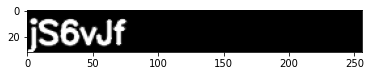

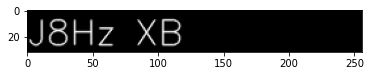

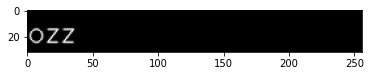

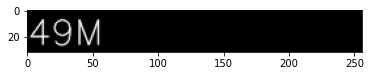

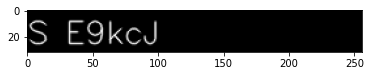

In [18]:
with tf.Graph().as_default():
  image_batch, label_batch=minibatch(batch_size, file_paths, image_size, max_char, class_count)
  init=tf.global_variables_initializer()
  with tf.Session() as sess:
    sess.run(init)
    sess.run(tf.local_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord) 
    for i in range(vis_image_count):
      image_b, label_b= sess.run([image_batch, label_batch])
      if(i == 0):
        print('data type of image:', type(image_b[0][0,0,0]))
        print('data type of label:', type(label_b[0][0,0]))
        print("shape of image_batch:", image_b.shape)
        print('shape of label_out:', label_b.shape)
      plt.imshow(np.reshape(image_b[0],[32,256]), cmap = 'gray')
      plt.show()
      if(show_label):
        print(sess.run(tf.transpose(label_b[0])))
    coord.request_stop()
    coord.join(threads)